# <center>Classifiers for Literacy Standard - Grade 3</center>

Cornell-Farrow and Garrard (2018). A Machine Learning Approach for Detecting Students at Risk of Low Academic Achievement. arXiv preprint. Number-to-come.

This notebook contains the code used to generate the classifiers for predicting whether students fall into the 'below standard' band in the literacy section of NAPLAN for grade 3. IP for this data set is not held by the authors and so may not be uploaded together with this code in order to facilitate reproduction. Instructions for how the data set may be obtained are outlined in the README file.

This notebook was executed on a quadcore Intel i7 2.60GHz cpu with 8GB of RAM. Runtime was about 5 minutes.


## Preprocessing

We begin by loading required packages and importing the data. The data are stored in a Stata .dta file.


In [1]:
library(readstata13)  # Importing data
library(ggplot2)      # Plotting
library(ggthemes)     # Themes for ggplot2
library(caret)        # Create training/test sets
library(rpart)        # Recursive partitioning decision tree classifier
library(rpart.plot)   # Plot the tree
library(pROC)         # Bulding ROC curves
library(DMwR)         # Constructing SMOTE sample
library(glmnet)       # Elastic net classifier
library(randomForest) # Random forest classifier
library(doMC)         # Run elastic net in parallel

start.time <- Sys.time()

# Import data
raw.data <- read.dta13('NAPLAN_data.dta')


Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: grid
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16


Attaching package: ‘glmnet’

The following object is masked from ‘package:pROC’:

    auc

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: iterators
Loading required package: parallel


We now summarize the raw data and remove columns not to be used as predictors.

In [2]:
print('Raw data summary.')
dim(raw.data)
summary(raw.data)


# Irrelevant predictors:
# schoolid, studentit, cohort
# readscore and mathscore were used 
# to construct readrisk and mathrisk.
ix <- c(1, 3, 4, 6, 15, 16)
data <- raw.data[, -ix]

# Only retain grade 3
data <- data[which(data$grade == 3), ]
# Remove grade, sameschool, previous scores
data <- data[, -c(2, 11:13)]
data <- data[complete.cases(data), ]

# Remove response variables
readrisk <- data[, 26]
mathrisk <- data[, 27]
data <- data[, -c(26, 27)]

# Attach response variable, make data frame
data <- data.frame(Class=readrisk, data)


# Summarize data.
print('Preprocessed data summary.')
dim(data)
summary(data)

dim(data)



[1] "Raw data summary."


[1] 2045434      37

    schoolid         priv          studentid            year       
 Min.   :   2   Min.   :0.0000   Min.   :      1   Min.   :0.0000  
 1st Qu.:2309   1st Qu.:0.0000   1st Qu.: 558104   1st Qu.:0.0000  
 Median :4698   Median :0.0000   Median :1117716   Median :0.0000  
 Mean   :4645   Mean   :0.3708   Mean   :1117467   Mean   :0.4999  
 3rd Qu.:6986   3rd Qu.:1.0000   3rd Qu.:1675980   3rd Qu.:1.0000  
 Max.   :9250   Max.   :1.0000   Max.   :2235804   Max.   :1.0000  
 NA's   :1588                    NA's   :1588                      
     grade           cohort           age            indig        
 Min.   :3.000   Min.   :    1   Min.   : 7.00   Min.   :0.00000  
 1st Qu.:3.000   1st Qu.:11346   1st Qu.: 9.20   1st Qu.:0.00000  
 Median :5.000   Median :23157   Median :11.20   Median :0.00000  
 Mean   :5.938   Mean   :22825   Mean   :11.48   Mean   :0.04528  
 3rd Qu.:7.000   3rd Qu.:34286   3rd Qu.:13.30   3rd Qu.:0.00000  
 Max.   :9.000   Max.   :45406   Max.   :17.50   Max. 

[1] "Preprocessed data summary."


[1] 324647     26

     Class             priv             age             indig        
 Min.   :0.0000   Min.   :0.0000   Min.   : 7.000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 8.300   1st Qu.:0.00000  
 Median :0.0000   Median :0.0000   Median : 8.600   Median :0.00000  
 Mean   :0.0286   Mean   :0.3661   Mean   : 8.586   Mean   :0.02385  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.: 8.800   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.0000   Max.   :10.600   Max.   :1.00000  
   mumschool       mumhighed        mumoccup       dadschool    
 Min.   :1.000   Min.   :5.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:4.000   1st Qu.:6.000   1st Qu.:2.000   1st Qu.:3.000  
 Median :4.000   Median :7.000   Median :3.000   Median :4.000  
 Mean   :3.557   Mean   :6.576   Mean   :3.896   Mean   :3.379  
 3rd Qu.:4.000   3rd Qu.:7.000   3rd Qu.:8.000   3rd Qu.:4.000  
 Max.   :4.000   Max.   :8.000   Max.   :8.000   Max.   :4.000  
   dadhighed        dadoccup          girl             

[1] 324647     26

Create a data frame with the dummy 'readrisk' as the response. Currently each variable is coded as a numeric. Turn the categorical/dummy variales into factors.

In [3]:

# Force variable types.
# Numeric types:
# 4, age; 13, readprev; 14, mathprev;
# 27, nstudent, 28, meanreadscore;
# 29, meanmathscore. The rest are 
# factors.
ix.numeric <- c(3, 24:26)
ix.factors <- setdiff(1:dim(data)[2], ix.numeric)

data[, ix.numeric] <- lapply(data[, ix.numeric], as.numeric)
data[, ix.factors] <- lapply(data[, ix.factors], as.factor)

       
# Display variable names and types
sapply(data, class)

# Now Remove raw.data from memory.
#rm(list=c('raw.data'))



Class          priv           age         indig     mumschool 
     "factor"      "factor"     "numeric"      "factor"      "factor" 
    mumhighed      mumoccup     dadschool     dadhighed      dadoccup 
     "factor"      "factor"      "factor"      "factor"      "factor" 
         girl           met    provincial        remote         lbote 
     "factor"      "factor"      "factor"      "factor"      "factor" 
           SA           NSW           TAS           VIC           QLD 
     "factor"      "factor"      "factor"      "factor"      "factor" 
           WA           ACT            NT      nstudent meanreadscore 
     "factor"      "factor"      "factor"     "numeric"     "numeric" 
meanmathscore 
    "numeric"

In [4]:
summary(data[which(data$Class==1), ])


 Class    priv          age         indig    mumschool mumhighed mumoccup
 0:   0   0:6823   Min.   : 7.400   0:8307   1: 896    5:3088    1: 814  
 1:9286   1:2463   1st Qu.: 8.200   1: 979   2:2295    6:1218    2:1293  
                   Median : 8.500            3:1355    7:1258    3:1952  
                   Mean   : 8.563            4:4740    8:3722    4:1578  
                   3rd Qu.: 8.800                                8:3649  
                   Max.   :10.600                                        
 dadschool dadhighed dadoccup girl     met      provincial remote   lbote   
 1:1190    5:4215    1: 927   0:6073   0:3683   0:6141     0:8748   0:7395  
 2:3053    6: 832    2:1654   1:3213   1:5603   1:3145     1: 538   1:1891  
 3:1208    7: 976    3:2569                                                 
 4:3835    8:3263    4:2918                                                 
                     8:1218                                                 
                    

## Sample splitting

Use a 2/3-1/3 split to obtain training and test sets.


In [5]:
set.seed(2718)

inTrain <- createDataPartition(
  y = data$Class,
  p = 2/3,
  list=F
)

train.data <- data[inTrain, ]
test.data <- data[-inTrain, ]

print('Training data summary')
dim(train.data)
summary(train.data)

print('Test data summary')
dim(test.data)
summary(test.data)


[1] "Training data summary"


[1] 216432     26

 Class      priv            age         indig      mumschool  mumhighed
 0:210241   0:137229   Min.   : 7.000   0:211255   1:  7027   5:52202  
 1:  6191   1: 79203   1st Qu.: 8.300   1:  5177   2: 27864   6:34328  
                       Median : 8.600              3: 18975   7:82666  
                       Mean   : 8.585              4:162566   8:47236  
                       3rd Qu.: 8.800                                  
                       Max.   :10.600                                  
 mumoccup  dadschool  dadhighed dadoccup  girl       met        provincial
 1:45129   1:  9844   5:74030   1:55775   0:109733   0: 52232   0:167456  
 2:42259   2: 41254   6:28707   2:56259   1:106699   1:164200   1: 48976  
 3:43823   3: 22444   7:71299   3:53437                                   
 4:24978   4:142890   8:42396   4:38293                                   
 8:60243                        8:12668                                   
                                              

[1] "Test data summary"


[1] 108215     26

 Class      priv           age         indig      mumschool mumhighed mumoccup 
 0:105120   0:68572   Min.   : 7.000   0:105649   1: 3447   5:26174   1:22521  
 1:  3095   1:39643   1st Qu.: 8.300   1:  2566   2:13963   6:17221   2:21250  
                      Median : 8.600              3: 9624   7:41296   3:21778  
                      Mean   : 8.587              4:81181   8:23524   4:12437  
                      3rd Qu.: 8.800                                  8:30229  
                      Max.   :10.600                                           
 dadschool dadhighed dadoccup  girl      met       provincial remote    
 1: 4871   5:37391   1:27866   0:55039   0:26117   0:83747    0:106566  
 2:20554   6:14263   2:28144   1:53176   1:82098   1:24468    1:  1649  
 3:11241   7:35601   3:26693                                            
 4:71549   8:20960   4:19274                                            
                     8: 6238                                            
  

## Weighted Classifiers

Here we train the weighted classifiers discussed in Section 3 of the paper. 

Let $y_{i} \in \{0, 1\}$ denote the true class for observation $i$, where $y_{i} = 1$ if a student is in the `below standard' category. We construct weights for each observation inversely proportional to the frequency of that observation's class. 
   
\begin{equation}
w_{i} = \frac{1}{2 | \{j : y_{j} = y_{i} \} |}
\end{equation}

glmnet only accepts matrices, not data frames, so we split the data frame into a response vector, y, and a model matrix, X.

In [6]:
# Model weights
train.weights <- ifelse(train.data$Class == 0,
                              (1/table(train.data$Class)[1]*.5),
                              (1/table(train.data$Class)[2]*0.5))

# Turn data frame into matrix
X <- model.matrix(Class ~., train.data)
y <- train.data$Class


### Elastic Net

The elastic net classifier minimizes the following objective function.

\begin{equation}
    \mathcal{L}(\hat{y}_{i}, y_{i}) = w_{i}l(\beta) + \lambda \left( (\alpha ||\beta||_{1} + (1-\alpha)\frac{1}{2} ||\beta||_{2}^{2}\right)
\end{equation}

We impose that the lasso and ridge penalties get equal weight, $\alpha = \frac{1}{2}$, with $\lambda$ being chosen by 10-fold cross-validation.

Passing the argument type.measure="class" to glmnet sets $l(\beta)$ to be the binary cross-entropy loss function.

In [7]:
# Register parallel session
registerDoMC(cores=3)

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
weight.EN.fit <- cv.glmnet(x=X,
                           y=y,
                           family="binomial",
                           alpha=0.5,
                           type.measure="class",
                           weights=train.weights,
                           parallel=T)
Sys.time() - t0


Time difference of 2.168835 mins

Plot the cross-validation curve; display coefficients,confusion matrix and performance measures on the test set.

41 x 1 sparse Matrix of class "dgCMatrix"
                         1
(Intercept)    8.230700002
(Intercept)    .          
priv1          .          
age            .          
indig1         0.244088937
mumschool2     .          
mumschool3     .          
mumschool4    -0.279704380
mumhighed6     .          
mumhighed7    -0.406206349
mumhighed8     0.028729852
mumoccup2      .          
mumoccup3      .          
mumoccup4      .          
mumoccup8      .          
dadschool2     .          
dadschool3     .          
dadschool4    -0.246328080
dadhighed6     .          
dadhighed7    -0.298339639
dadhighed8     .          
dadoccup2      .          
dadoccup3      .          
dadoccup4      0.034808456
dadoccup8      0.066602118
girl1         -0.484120384
met1          -0.003668850
provincial1    .          
remote1        .          
lbote1         .          
SA1            .          
NSW1           .          
TAS1           .          
VIC1          -0.013513701
QLD1         

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 74107   859
         1 31013  2236
                                          
               Accuracy : 0.7055          
                 95% CI : (0.7027, 0.7082)
    No Information Rate : 0.9714          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0746          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.72246         
            Specificity : 0.70498         
         Pos Pred Value : 0.06725         
         Neg Pred Value : 0.98854         
             Prevalence : 0.02860         
         Detection Rate : 0.02066         
   Detection Prevalence : 0.30725         
      Balanced Accuracy : 0.71372         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           72.245557            70.497527             6.725014 
      Neg Pred Value            Precision               Recall 
           98.854147             6.725014            72.245557 
                  F1           Prevalence       Detection Rate 
           12.304645             2.860047             2.066257 
Detection Prevalence    Balanced Accuracy 
           30.724946            71.371542

[1] "AUC"


Area under the curve: 0.7873

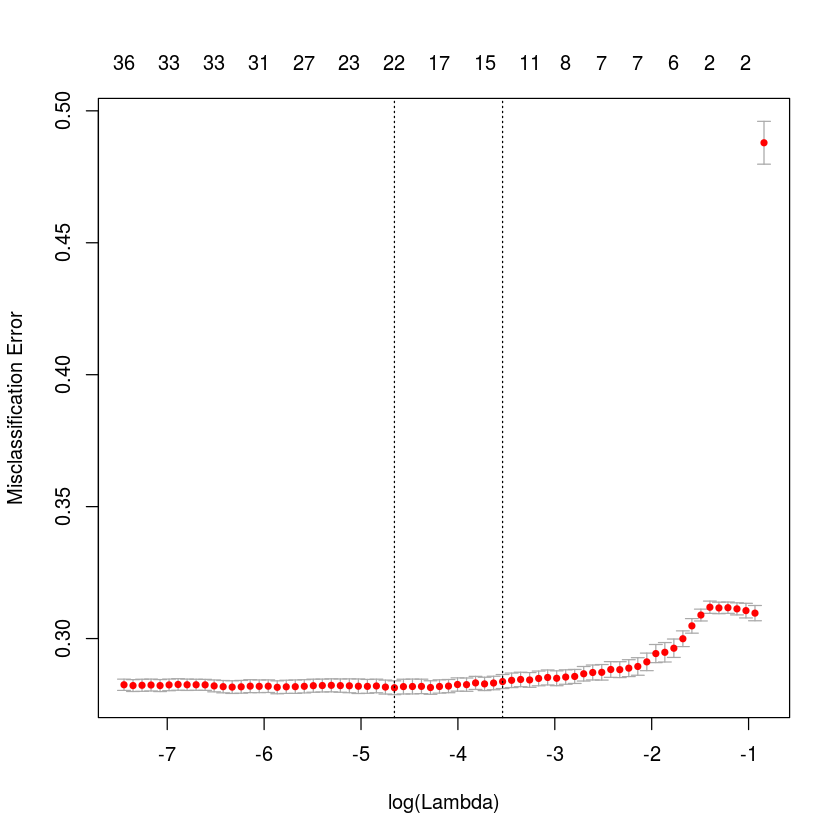

In [8]:
# Cross-validation curve
plot(weight.EN.fit)

# Estimated coefficients
coef(weight.EN.fit, s='lambda.1se')

# Confusion matrix
weight.EN.preds <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
weight.EN.CM <- confusionMatrix(as.factor(weight.EN.preds), test.data[, 1], positive=c('1'))
weight.EN.CM

# Sensitivity/specificity/precision/F1/accuracy
weight.EN.CM$byClass*100

# ROC curve
weight.EN.probs <- predict(weight.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
weight.EN.roc <- roc(test.data[, 1], as.numeric(weight.EN.probs))

# Display area under the ROC curve
print('AUC')
weight.EN.roc$auc



### Classification Tree

Train a recursive partitioning tree using rpart.

In [9]:
t0 <- Sys.time()
weight.cart.fit <- rpart(Class ~.,
                         data=train.data,
                         weights = train.weights)
t1 <- Sys.time() - t0
t1

Time difference of 33.2124 secs

Show confusion matrix for test set, performance metrics, and plot the tree.

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 73601  1005
         1 31519  2090
                                          
               Accuracy : 0.6995          
                 95% CI : (0.6967, 0.7022)
    No Information Rate : 0.9714          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0649          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.67528         
            Specificity : 0.70016         
         Pos Pred Value : 0.06219         
         Neg Pred Value : 0.98653         
             Prevalence : 0.02860         
         Detection Rate : 0.01931         
   Detection Prevalence : 0.31058         
      Balanced Accuracy : 0.68772         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           67.528271            70.016172             6.218572 
      Neg Pred Value            Precision               Recall 
           98.652923             6.218572            67.528271 
                  F1           Prevalence       Detection Rate 
           11.388405             2.860047             1.931340 
Detection Prevalence    Balanced Accuracy 
           31.057617            68.772222

[1] "AUC"


Area under the curve: 0.6877

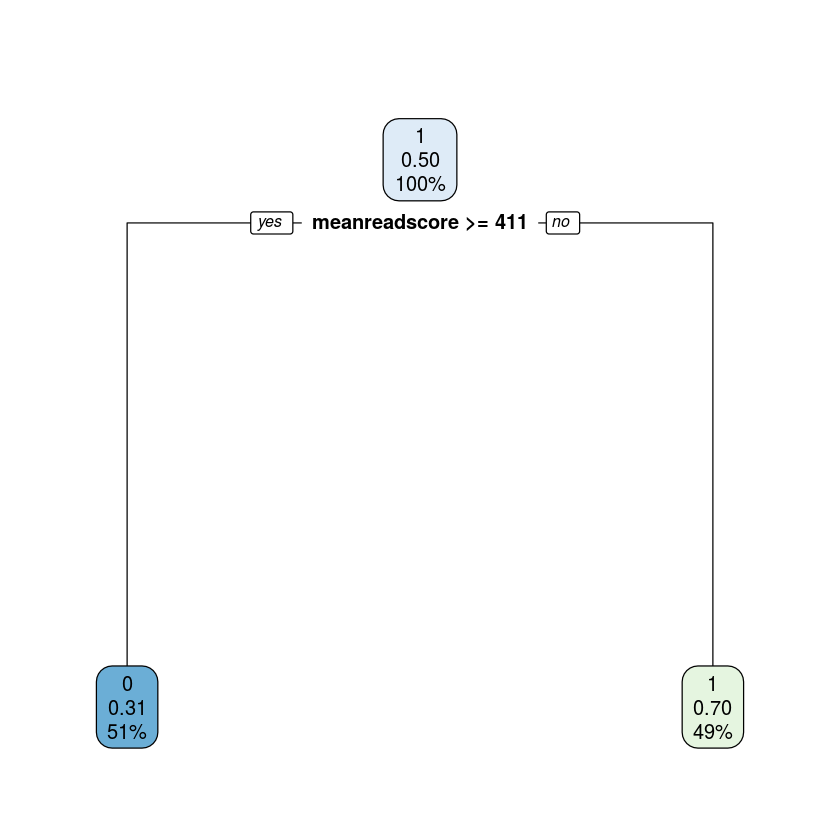

In [10]:
# Confusion matrix
weight.cart.preds <- predict(weight.cart.fit, newdata=test.data[, -1], type='class')
weight.cart.CM <- confusionMatrix(weight.cart.preds, test.data[, 1], positive="1")
weight.cart.CM
weight.cart.CM$byClass*100

# ROC curve
weight.oos.probs <- predict(weight.cart.fit, newdata=test.data[, -1])[, 2]
weight.roc <- roc(test.data[, 1], weight.oos.probs)
print('AUC')
weight.roc$auc


# Plot the tree
rpart.plot(weight.cart.fit,
           cex=1,
           fallen.leaves=T)


## SMOTE Classifiers

We balance the training set by generating a SMOTE sample using the out-of-the-box settings.

In [11]:
# Generate SMOTE sample
SMOTE.data <- SMOTE(Class ~., train.data)
dim(SMOTE.data)
summary(SMOTE.data)

# Turn into matrices
X <- model.matrix(Class ~., SMOTE.data)
y <- SMOTE.data$Class

[1] 43337    26

 Class     priv           age         indig     mumschool mumhighed mumoccup 
 0:24764   0:27093   Min.   : 7.000   0:37558   1: 3540   5:11655   1: 7222  
 1:18573   1:16244   1st Qu.: 8.300   1: 5779   2: 7911   6: 6219   2: 7372  
                     Median : 8.556             3: 4867   7:12343   3: 8604  
                     Mean   : 8.564             4:27019   8:13120   4: 6238  
                     3rd Qu.: 8.800                                 8:13901  
                     Max.   :10.400                                          
 dadschool dadhighed dadoccup  girl      met       provincial remote   
 1: 4420   5:15818   1: 8352   0:22759   0:15467   0:31183    0:40042  
 2:10306   6: 5113   2: 9813   1:20578   1:27870   1:12154    1: 3295  
 3: 4866   7:10311   3:10630                                           
 4:23745   8:12095   4: 9898                                           
                     8: 4644                                           
                      

### Elastic Net (SMOTE)

Now run the elastic net and tree, but without class weights this time.

In [12]:

# Estimate the elastic net classifier
t0 <- Sys.time()
set.seed(2718)
SMOTE.EN.fit <- cv.glmnet(x=X,
                          y=y,
                          family="binomial",
                          alpha=0.5,
                          type.measure="class",
                        parallel=T)
Sys.time() - t0

Time difference of 20.25052 secs

Display coefficients, CV curve, confusion matrix, performance measures.

41 x 1 sparse Matrix of class "dgCMatrix"
                          1
(Intercept)    9.388943e+00
(Intercept)    .           
priv1          3.778632e-01
age            .           
indig1         1.793249e+00
mumschool2    -6.147078e-02
mumschool3    -1.242503e-01
mumschool4    -6.221963e-01
mumhighed6     .           
mumhighed7    -2.993365e-01
mumhighed8     1.032547e-01
mumoccup2      .           
mumoccup3     -2.583717e-02
mumoccup4      .           
mumoccup8      .           
dadschool2    -1.196102e-01
dadschool3    -2.060871e-01
dadschool4    -4.696771e-01
dadhighed6     .           
dadhighed7    -2.405319e-01
dadhighed8     1.405411e-01
dadoccup2     -1.202562e-02
dadoccup3      .           
dadoccup4      1.037960e-01
dadoccup8      4.895230e-01
girl1         -3.309346e-01
met1          -3.507844e-01
provincial1    7.479406e-02
remote1        8.408122e-01
lbote1         5.081988e-01
SA1           -5.900268e-02
NSW1          -1.185702e-01
TAS1           1.259056e-01
VIC1  

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 90671  1587
         1 14449  1508
                                          
               Accuracy : 0.8518          
                 95% CI : (0.8497, 0.8539)
    No Information Rate : 0.9714          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1159          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.48724         
            Specificity : 0.86255         
         Pos Pred Value : 0.09450         
         Neg Pred Value : 0.98280         
             Prevalence : 0.02860         
         Detection Rate : 0.01394         
   Detection Prevalence : 0.14746         
      Balanced Accuracy : 0.67489         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           48.723748            86.254756             9.450398 
      Neg Pred Value            Precision               Recall 
           98.279824             9.450398            48.723748 
                  F1           Prevalence       Detection Rate 
           15.830359             2.860047             1.393522 
Detection Prevalence    Balanced Accuracy 
           14.745645            67.489252

[1] "AUC"


Area under the curve: 0.7746

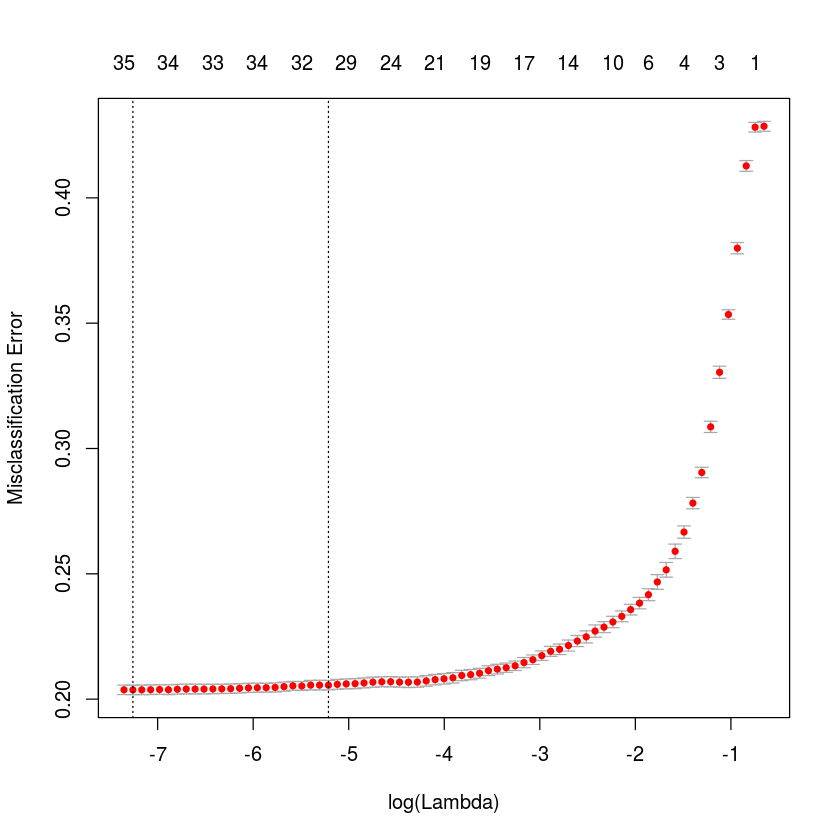

In [13]:
# Coefficients
coef(SMOTE.EN.fit, s='lambda.1se')

# Confusion matrix
SMOTE.EN.preds <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='class')
SMOTE.EN.CM <- confusionMatrix(as.factor(SMOTE.EN.preds), test.data[, 1], positive=c('1'))
SMOTE.EN.CM
SMOTE.EN.CM$byClass*100

# ROC curve
SMOTE.EN.probs <- predict(SMOTE.EN.fit, s='lambda.1se', model.matrix(Class ~., test.data), type='response')
SMOTE.EN.roc <- roc(test.data[, 1], as.numeric(SMOTE.EN.probs))

print('AUC')
SMOTE.EN.roc$auc

# CV curve
plot(SMOTE.EN.fit)


### Decision Tree (SMOTE)


In [14]:
t0 <- Sys.time()
SMOTE.cart.fit <- rpart(Class ~.,
                    data=SMOTE.data)
t1 <- Sys.time() - t0
t1


Time difference of 3.282831 secs

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 90010  1631
         1 15110  1464
                                          
               Accuracy : 0.8453          
                 95% CI : (0.8431, 0.8474)
    No Information Rate : 0.9714          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1058          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.47302         
            Specificity : 0.85626         
         Pos Pred Value : 0.08833         
         Neg Pred Value : 0.98220         
             Prevalence : 0.02860         
         Detection Rate : 0.01353         
   Detection Prevalence : 0.15316         
      Balanced Accuracy : 0.66464         
                                          
       'Positive' Class : 1               
                                          

Sensitivity          Specificity       Pos Pred Value 
           47.302100            85.625951             8.833112 
      Neg Pred Value            Precision               Recall 
           98.220229             8.833112            47.302100 
                  F1           Prevalence       Detection Rate 
           14.886369             2.860047             1.352862 
Detection Prevalence    Balanced Accuracy 
           15.315806            66.464026

[1] "AUC"


Area under the curve: 0.7169

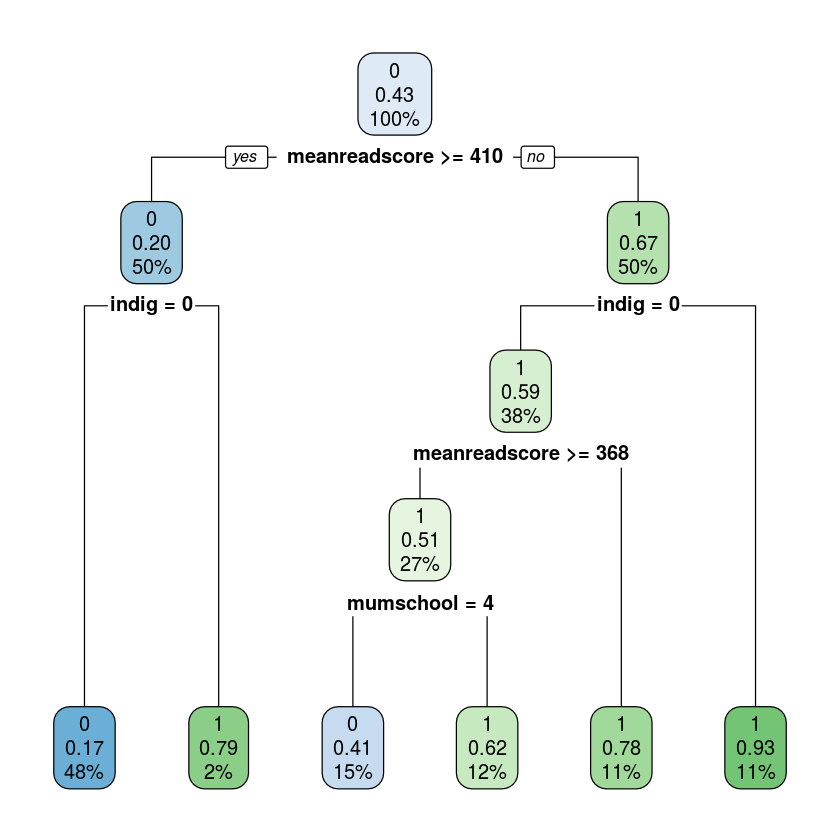

In [15]:
# Confusion Matrix
SMOTE.cart.preds <- predict(SMOTE.cart.fit, newdata=test.data[, -1], type='class')
SMOTE.cart.CM <- confusionMatrix(SMOTE.cart.preds, test.data[, 1], positive="1")
SMOTE.cart.CM
SMOTE.cart.CM$byClass*100

# ROC curve
SMOTE.cart.oos.probs <- predict(SMOTE.cart.fit, newdata=test.data[, -1])[, 2]
SMOTE.cart.roc <- roc(test.data[, 1], SMOTE.cart.oos.probs)
print("AUC")
SMOTE.cart.roc$auc

# Plot tree
rpart.plot(SMOTE.cart.fit,
           cex=1,
           fallen.leaves=T)


## Random Forest (SMOTE)

Now let's train a random forest on the SMOTE sample. Use an ensemble of 200 trees.



In [16]:
t0 <- Sys.time()
set.seed(2718)
rf.fit <- randomForest(x=X,
                       y=y,
                       ntree = 200)
Sys.time() - t0


Time difference of 1.065114 mins

Plot variable importance.

png 
  2

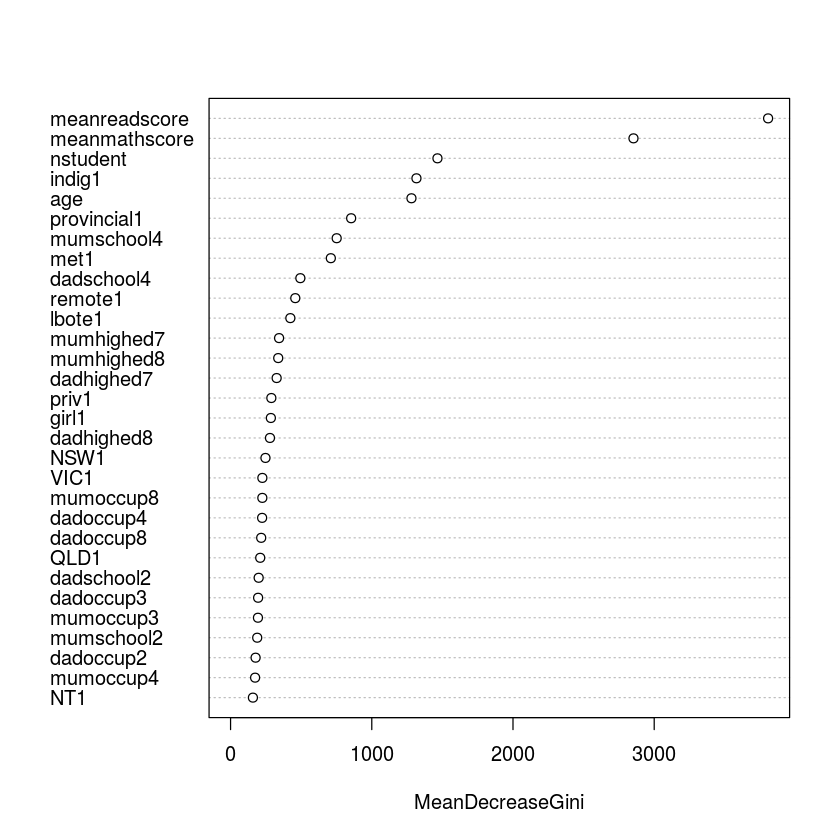

In [17]:
setEPS()
postscript("RF_varimp_Lit_G3.eps", fonts=c('serif'))
varImpPlot(rf.fit, type=2, main="")
dev.off()

varImpPlot(rf.fit, type=2, main="")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 93033  1763
         1 12087  1332
                                       
               Accuracy : 0.872        
                 95% CI : (0.87, 0.874)
    No Information Rate : 0.9714       
    P-Value [Acc > NIR] : 1            
                                       
                  Kappa : 0.1204       
 Mcnemar's Test P-Value : <2e-16       
                                       
            Sensitivity : 0.43037      
            Specificity : 0.88502      
         Pos Pred Value : 0.09926      
         Neg Pred Value : 0.98140      
             Prevalence : 0.02860      
         Detection Rate : 0.01231      
   Detection Prevalence : 0.12400      
      Balanced Accuracy : 0.65769      
                                       
       'Positive' Class : 1            
                                       

Sensitivity          Specificity       Pos Pred Value 
           43.037157            88.501712             9.926224 
      Neg Pred Value            Precision               Recall 
           98.140217             9.926224            43.037157 
                  F1           Prevalence       Detection Rate 
           16.131767             2.860047             1.230883 
Detection Prevalence    Balanced Accuracy 
           12.400314            65.769435

[1] "AUC"


Area under the curve: 0.7741

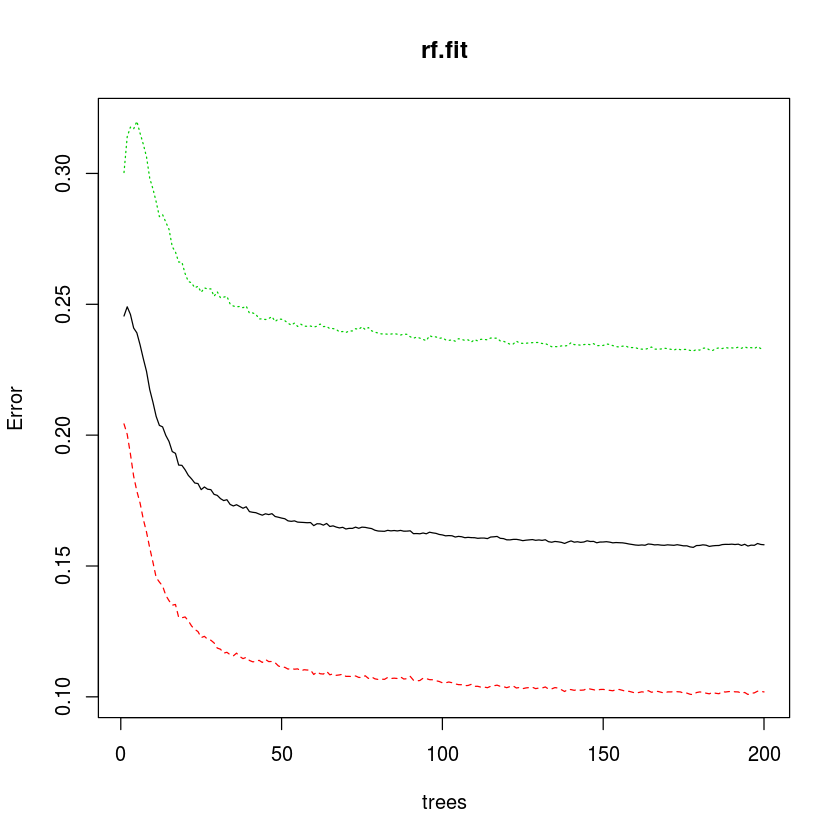

In [18]:
# Confusion matrix
rf.preds <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='class')
rf.CM <- confusionMatrix(rf.preds, test.data[, 1], positive="1")
rf.CM
rf.CM$byClass*100

# ROC curve
SMOTE.rf.oos.probs <- predict(rf.fit, newdata=model.matrix(Class ~., test.data), type='prob')[, 2]
SMOTE.rf.roc <- roc(test.data[, 1], SMOTE.rf.oos.probs)
print("AUC")
SMOTE.rf.roc$auc

# Plot the random forest training curves
plot(rf.fit)


## ROC Curves

We've saved the individual ROC curves for each of the 5 classifiers. Let's plot them all together on the one graph. First get all the data together in a data frame for ggplot2.

In [19]:
weight.EN.roc.df <- data.frame(Sens=weight.EN.roc$sensitivities, Spec=weight.EN.roc$specificities, Classifier='Weighted EN')
weight.roc.df <- data.frame(Sens=weight.roc$sensitivities, Spec=weight.roc$specificities, Classifier='Weighted Tree')
SMOTE.EN.roc.df <- data.frame(Sens=SMOTE.EN.roc$sensitivities, Spec=SMOTE.EN.roc$specificities, Classifier='SMOTE EN')
SMOTE.cart.roc.df <- data.frame(Sens=SMOTE.cart.roc$sensitivities, Spec=SMOTE.cart.roc$specificities, Classifier='SMOTE Tree')
SMOTE.rf.roc.df <- data.frame(Sens=SMOTE.rf.roc$sensitivities, Spec=SMOTE.rf.roc$specificities, Classifier='SMOTE RF')


# For some reason the Elastic Net ROC curves have a huge number of data points.
# Down sample them in order to plot the ROC curve
ix <- sample(nrow(weight.EN.roc.df), 50, replace = F)
weight.EN.roc.df <- weight.EN.roc.df[ix, ]
ix <- sample(nrow(SMOTE.EN.roc.df), 50, replace = F)
SMOTE.EN.roc.df <- SMOTE.EN.roc.df[ix, ]

all.rocs <- rbind(weight.EN.roc.df,
                  weight.roc.df,
                  SMOTE.EN.roc.df,
                  SMOTE.cart.roc.df,
                  SMOTE.rf.roc.df)


Now plot the curves.

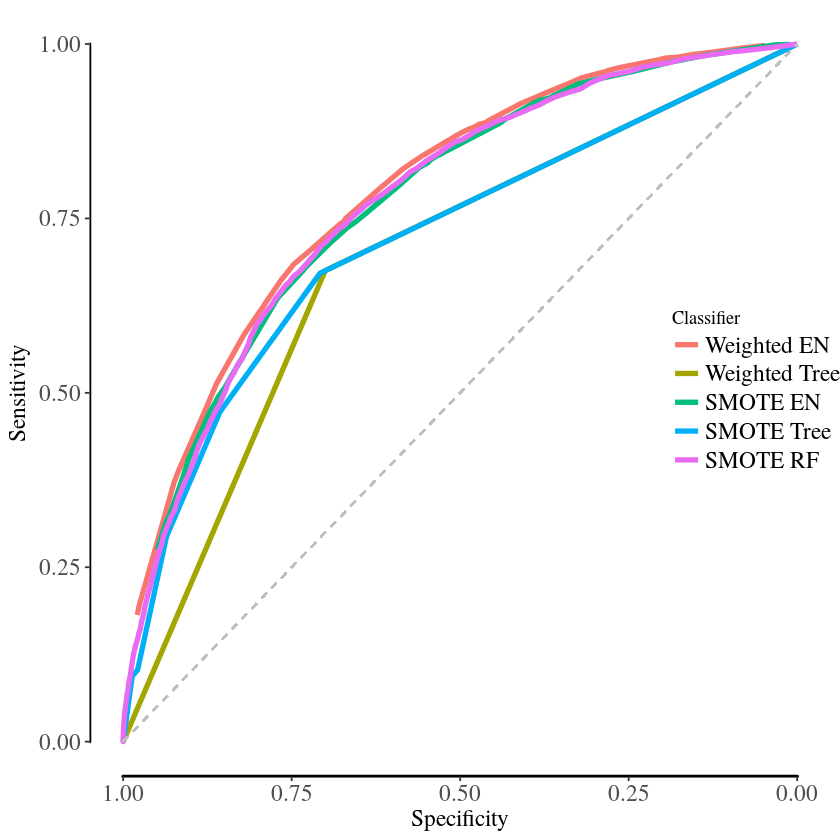

In [20]:
ROC1 <- ggplot(data=all.rocs, aes(x=Spec, y=Sens, color=Classifier)) +  
      geom_line(stat='identity', cex=1.5)+
      scale_x_reverse() + 
      geom_rangeframe(color='black', cex=1) + 
      theme_tufte() + 
      xlab('Specificity') + 
      ylab('Sensitivity') + 
      geom_segment(aes(x = 1, xend = 0, y = 0, yend =1), linetype='dashed', color='grey', size=0.5)+
      theme (axis.text.x = element_text(size=14),
         axis.text.y = element_text(size=14),
         axis.title = element_text(size=14),
         legend.text = element_text(size=14),
         legend.position = c(.9, .5))  
ROC1

## Cleaning Up

Let's put the relevant outputs into a clean form so that they can be copied into the paper. 

Start by saving our decision trees and ROC curve to disk in postscript format.


In [21]:
# Weighted tree
setEPS()
postscript("G3_Lit_Weighted_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(weight.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

# Smote tree
setEPS()
postscript("G3_Lit_Smote_Tree.eps", width=23, height=10, pointsize=12)
rpart.plot(SMOTE.cart.fit,
           cex=1.5,
           fallen.leaves=T)
dev.off()

setEPS()
postscript("G3_ROC_Lit.eps", fonts=c('serif'))
ROC1
dev.off()



png 
  2

png 
  2

png 
  2

Next, we'll prep the elastic net coefficients. We want a LaTeX table with five columns: 1) variable names; 2)literacy/weighted coefficients; 3) literacy SMOTE coefs; 4) numeracy weighted; 5) numeracy SMOTE.

Let's stick the variable names, literacy weighted, and literacy SMOTE data into a data frame which we can load when the numeracy results are finished. Then we'll save the whole thing in one LaTeX table.

In [22]:
# Weighted EN
Cw <- coef(weight.EN.fit)

# Extract variable names.
var.names <- row.names(Cw)

# Round the coefficients to 2SF.
Cw <- round(Cw[, 1], 2)

# SMOTE EN
Cs <- coef(SMOTE.EN.fit)
Cs <- round(Cs[, 1], 2)

EN <- data.frame(Variable=var.names, Weighted=Cw, SMOTE=Cs)

# Note that there are two instances of 'intercept'. 
# Remove the second.
EN <- EN[-2, ]

# All set. Once the numeracy numbers are done,
# we'll just cbind them into the data frame 
# and save them with xtable.
save(EN, file='G3ElasticNetCoefs.Rda')

Finally, let's save our workspace.

In [23]:
save.image('literacy_workspace_grade_3.RData')
print('Finished.') 
Sys.time() - start.time

[1] "Finished."


Time difference of 6.551356 mins